In [27]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV, ParameterSampler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [28]:
# load dataset
df = pd.read_csv('../../datasets/atis_dataset_preprocessed.csv', sep=';')

In [29]:
# define label columns
label_columns = ['ILS', 'RNAV', 'RNP', 'VISUAL']

# define features and targets
X = df.drop(columns=label_columns)

# one-hot encode features that are categorical
X = pd.get_dummies(X, columns=['airport_icao', 'runway_designator_side', 'weather_phenomenon', 
                                'runway_designator_number', 'rvr_tendency', 'runway_ils_category'])

In [30]:
y = df[label_columns]

In [31]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# define model
base_model = MultiOutputClassifier(XGBClassifier(eval_metric='logloss'))

# hyperparameter tuning
params = {
    'estimator__n_estimators': [100, 200, 300, 400, 500],
    'estimator__learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'estimator__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'estimator__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'estimator__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=params,
    n_iter=50,
    cv=3,
    scoring='f1_micro',
    verbose=2,
    n_jobs=1
)

# build and train multi-label model
search.fit(X_train, y_train)

# pick the best model
model = search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.3, estimator__max_depth=9, estimator__n_estimators=200, estimator__subsample=0.8; total time=   0.7s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.3, estimator__max_depth=9, estimator__n_estimators=200, estimator__subsample=0.8; total time=   0.6s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.3, estimator__max_depth=9, estimator__n_estimators=200, estimator__subsample=0.8; total time=   0.6s
[CV] END estimator__colsample_bytree=1.0, estimator__learning_rate=0.3, estimator__max_depth=5, estimator__n_estimators=500, estimator__subsample=0.9; total time=   1.4s
[CV] END estimator__colsample_bytree=1.0, estimator__learning_rate=0.3, estimator__max_depth=5, estimator__n_estimators=500, estimator__subsample=0.9; total time=   1.3s
[CV] END estimator__colsample_bytree=1.0, estimator__learning_rate=0.3, estimator__max_d

In [33]:
print(search.best_params_)

{'estimator__subsample': 0.9, 'estimator__n_estimators': 200, 'estimator__max_depth': 8, 'estimator__learning_rate': 0.05, 'estimator__colsample_bytree': 0.6}


In [34]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__subsample,param_estimator__n_estimators,param_estimator__max_depth,param_estimator__learning_rate,param_estimator__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
37,0.844099,0.014364,0.045343,0.007076,0.9,200,8,0.05,0.6,"{'estimator__subsample': 0.9, 'estimator__n_es...",0.953770,0.966013,0.958580,0.959454,0.005037,1
3,1.214337,0.038962,0.047595,0.006613,1.0,300,10,0.05,0.6,"{'estimator__subsample': 1.0, 'estimator__n_es...",0.954093,0.965815,0.958236,0.959381,0.004854,2
26,1.637128,0.151753,0.054965,0.007829,0.9,400,8,0.05,0.5,"{'estimator__subsample': 0.9, 'estimator__n_es...",0.953414,0.964947,0.956677,0.958346,0.004854,3
40,1.013931,0.030951,0.038419,0.000840,0.8,400,5,0.05,0.5,"{'estimator__subsample': 0.8, 'estimator__n_es...",0.952771,0.965617,0.956413,0.958267,0.005405,4
45,1.143617,0.119864,0.056109,0.006957,0.9,200,10,0.10,0.5,"{'estimator__subsample': 0.9, 'estimator__n_es...",0.952855,0.962711,0.957878,0.957815,0.004024,5


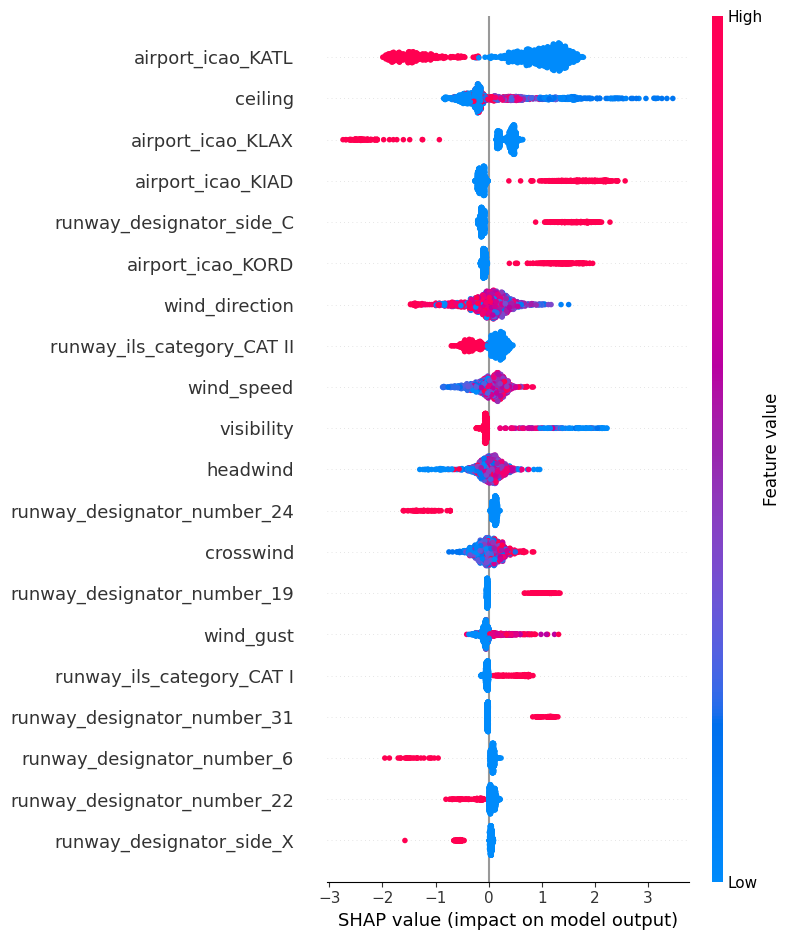

In [35]:
# ILS SHAP
explainer_ILS = shap.TreeExplainer(model.estimators_[0])
shap_ILS = explainer_ILS.shap_values(X_test)
shap.summary_plot(shap_ILS, X_test)

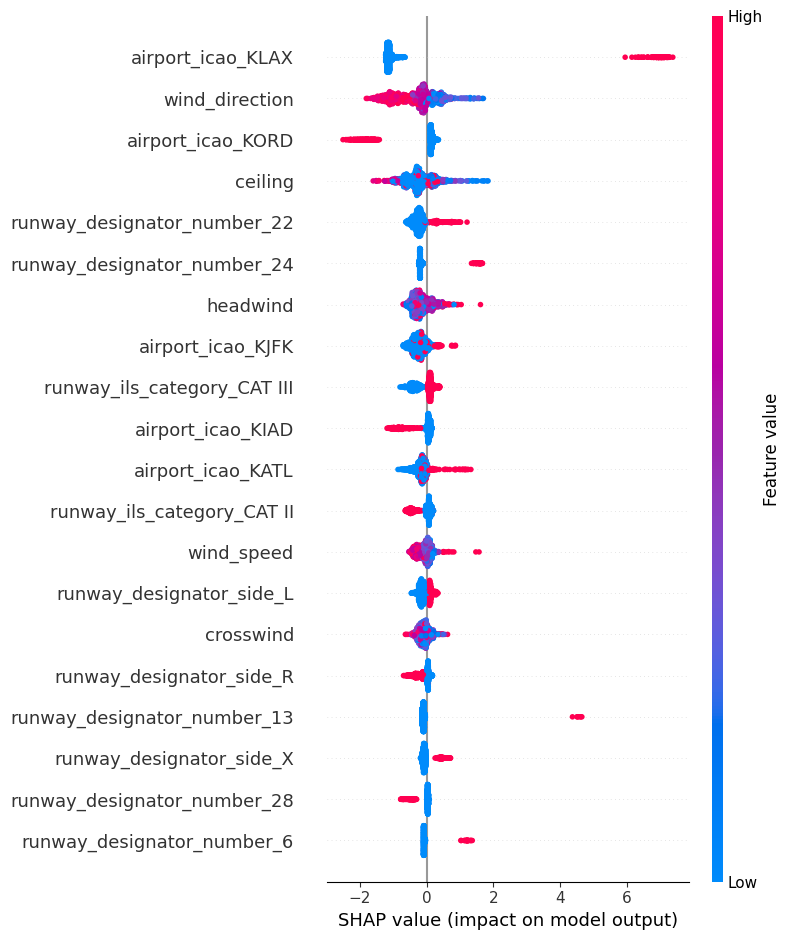

In [36]:
# RNAV SHAP
explainer_RNAV = shap.TreeExplainer(model.estimators_[1])
shap_RNAV = explainer_RNAV.shap_values(X_test)
shap.summary_plot(shap_RNAV, X_test)

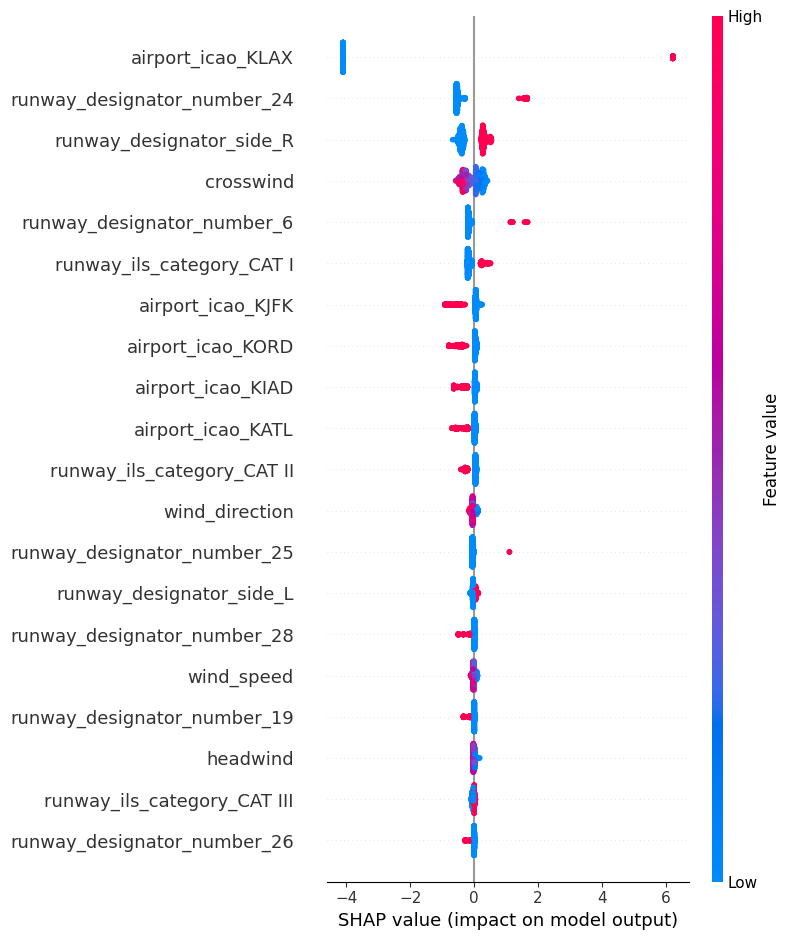

In [37]:
# RNP SHAP
explainer_RNP = shap.TreeExplainer(model.estimators_[2])
shap_RNP = explainer_RNP.shap_values(X_test)
shap.summary_plot(shap_RNP, X_test)

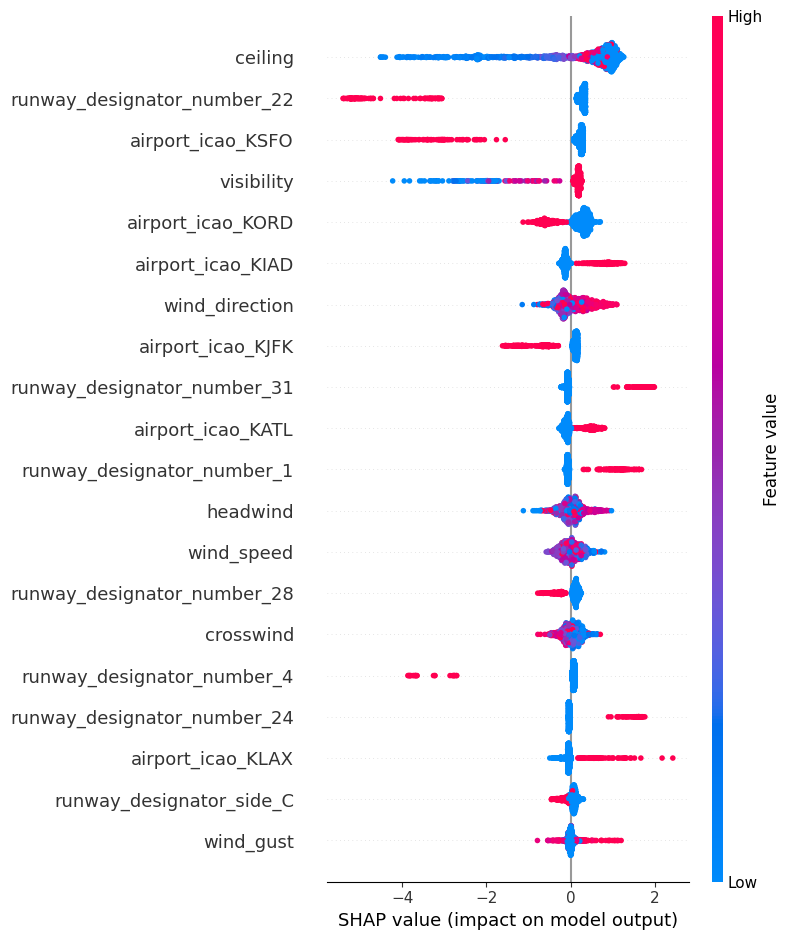

In [38]:
# VISUAL SHAP
explainer_VISUAL = shap.TreeExplainer(model.estimators_[3])
shap_VISUAL = explainer_VISUAL.shap_values(X_test)
shap.summary_plot(shap_VISUAL, X_test)

In [39]:
# predict and evaluate
y_pred = model.predict(X_test)
empty_mask = y_pred.sum(axis=1) == 0
no_predictions = np.sum(empty_mask)
print(f"Samples with no predicted labels: {no_predictions} out of {len(y_pred)}")
print(X_test[empty_mask])
print(classification_report(y_test, y_pred, target_names=label_columns, zero_division=0))

Samples with no predicted labels: 1 out of 1319
      visibility  wind_speed  wind_gust  wind_direction     rvr  headwind  \
5589        10.0           6          0             130  6000.0       0.0   

      crosswind  ceiling  airport_icao_KATL  airport_icao_KIAD  ...  \
5589        6.0     -1.0              False              False  ...   

      runway_designator_number_28  runway_designator_number_30  \
5589                        False                        False   

      runway_designator_number_31  rvr_tendency_Deteriorating  \
5589                        False                       False   

      rvr_tendency_Excellent  rvr_tendency_Improving  rvr_tendency_Stable  \
5589                    True                   False                False   

      runway_ils_category_CAT I  runway_ils_category_CAT II  \
5589                      False                       False   

      runway_ils_category_CAT III  
5589                         True  

[1 rows x 70 columns]
             